## Bayesian Optimization of beam emittance at LCLS-II

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../../")
    sys.path.append("../")

import xopt
print(xopt.__version__)

# set up data saving locations
data_dir = "/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit"

run_name = "optimize_4"
run_dir = f"{data_dir}/{run_name}"
import os
if not os.path.exists(run_dir):
    os.mkdir(run_dir)

2.0a1+63.g53057de


In [2]:
from scripts.evaluate_function.screen_image import measure_beamsize, measure_background
from scripts.characterize_emittance import characterize_emittance

In [3]:
from utils import VARIABLE_RANGES, SCAN_VARIABLE, \
    MEASUREMENT_OPTIONS, IMAGE_CONSTRAINTS, SCREEN_NAME, BEAM_ENERGY, QUAD_LENGTH, \
    PV_TO_INTEGRATED_GRADIENT, DRIFT_LENGTH, eval_beamsize

## (Optional) Measure background image

In [4]:
MEASURE_BACKGROUND = False
BACKGROUND_FILE = f"{data_dir}/{SCREEN_NAME}_background.npy".replace(":","_")

if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)

import pandas as pd
MEASUREMENT_OPTIONS["background"] = BACKGROUND_FILE
MEASUREMENT_OPTIONS["n_shots"] = 3
MEASUREMENT_OPTIONS["visualize"] = False
MEASUREMENT_OPTIONS["save_img_location"] = run_dir
#MEASUREMENT_OPTIONS["roi"] = pd.Series([600,625,700,700])


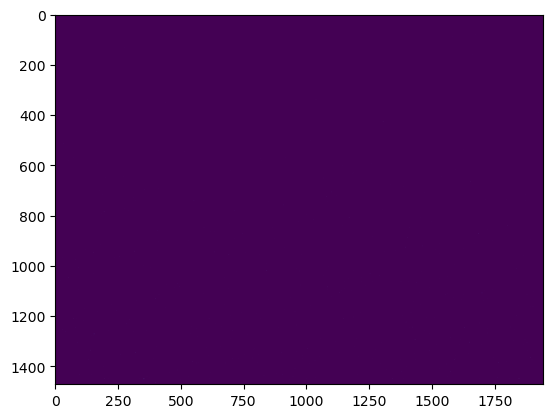

In [5]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE))

## Define measurement parameters

In [7]:
from xopt import VOCS
import numpy as np
from emitopt.utils import get_quad_strength_conversion_factor
from time import sleep 
from epics import caput

EXPLORATION_VARIABLES = [
    "SOLN:GUNB:212:BCTRL","SOLN:GUNB:823:BCTRL", 
    "QUAD:GUNB:212:1:BCTRL", "QUAD:GUNB:212:2:BCTRL",
    "QUAD:GUNB:823:1:BCTRL","QUAD:GUNB:823:2:BCTRL"]

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
QUAD_STRENGTH_SCALE =  PV_TO_INTEGRATED_GRADIENT * \
           integrated_gradient_to_geometric_focusing_strength

SCAN_NUMBER = 0

def eval_emittance(inputs: dict):
    global SCAN_NUMBER
    global run_dir

    for name in EXPLORATION_VARIABLES:
        print(f'CAPUT {name} {inputs[name]}')
        caput(name, inputs[name])

    sleep(3.0)

    VARIABLE_RANGES["QUAD:HTR:120:BCTRL"] = [-2.2, -1.8]

    emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        constants = inputs,
        observables = ["S_x_mm", "S_y_mm"],
        constraints = IMAGE_CONSTRAINTS
    )
    print(emit_vocs)

    print(f"running emittance characterization scan number {SCAN_NUMBER}")
    results, _ = characterize_emittance(
        emit_vocs,
        eval_beamsize,
        quad_length=QUAD_LENGTH,
        drift_length=DRIFT_LENGTH,
        beam_energy=BEAM_ENERGY,
        quad_strength_scale_factor=QUAD_STRENGTH_SCALE,
        quad_strength_key=SCAN_VARIABLE,
        rms_x_key="S_x_mm",
        rms_y_key="S_y_mm",
        n_initial=1,
        n_iterations=4,
        dump_file=f"{run_dir}/scan_{SCAN_NUMBER}.yml"
    )
    results["mean_emittance"] = np.sqrt(results["x_emittance_median"] * results["y_emittance_median"])

    SCAN_NUMBER += 1
    return results

## Set up optimization

In [7]:
#import yaml
#d= yaml.safe_load(open('/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/optimize_2/optimize_emittance.yml'))
#data = pd.DataFrame(d['data'])

In [10]:
{ele: VARIABLE_RANGES[ele] for ele in EXPLORATION_VARIABLES}

{'SOLN:GUNB:212:BCTRL': [0.044, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.021, 0.0255],
 'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005]}

In [ ]:
{'SOLN:GUNB:212:BCTRL': [0.044, 0.0444],
 'SOLN:GUNB:823:BCTRL': [0.022, 0.0237],
 'QUAD:GUNB:212:1:BCTRL': [0.0011, 0.00133],
 'QUAD:GUNB:212:2:BCTRL': [0.0020, 0.0025],
 'QUAD:GUNB:823:1:BCTRL': [0.00030,0.0004],
 'QUAD:GUNB:823:2:BCTRL': [0.0005, 0.00092]}

In [9]:
from xopt.evaluator import Evaluator
from xopt.generators import UpperConfidenceBoundGenerator
from xopt import Xopt

vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in EXPLORATION_VARIABLES},
        constants = MEASUREMENT_OPTIONS,
        objectives = {"mean_emittance":"MINIMIZE"},
    )

evaluator = Evaluator(function=eval_emittance)
generator = UpperConfidenceBoundGenerator(vocs=vocs)
generator.max_travel_distances = [0.2] * 6
generator.numerical_optimizer.n_raw_samples = 128
generator.numerical_optimizer.n_restarts = 128

generator.model_constructor.use_low_noise_prior = False

# reset SCAN_NUMBER
SCAN_NUMBER = 0

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)#, data=data)
X.options.dump_file = f"{run_dir}/optimize_emittance.yml"
X


            Xopt
________________________________
Version: 2.0a1+63.g53057de
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: /home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/optimize_4/optimize_emittance.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 128, n_restarts: 128, max_iter: 2000}
  max_travel_distances: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
  fixed_features: null
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: __main__.eval_emittance
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    SOLN:GUNB:212:BCTRL: [0.044, 0.0444]
    SOLN:GUNB:823:BCTRL: [0.022, 0.0237]
    QUAD:GUNB:212:1:BCTRL: [0.0011, 0.00133]
    QUAD:GUNB:212:2:BCTRL:

In [9]:
#start from new

In [10]:
X.data

""


In [11]:
## Evaluate initial points
nominal_pt = {'SOLN:GUNB:212:BCTRL': 0.04415,
 'QUAD:GUNB:212:1:BCTRL': 0.001291535,
 'QUAD:GUNB:212:2:BCTRL': 0.002308284,
 'SOLN:GUNB:823:BCTRL': 0.0229917,
 'QUAD:GUNB:823:1:BCTRL': 0.0003319,
 'QUAD:GUNB:823:2:BCTRL': 0.000888072
             }

def nearby_points(initial_dict):
    output = {}
    for name, x0 in initial_dict.items():
        name = name.replace('BACT', 'BCTRL')
        #print(name)
        
        if name in X.vocs.variables:
            xmin, xmax = X.vocs.variables[name]
            
            ptp = xmax - xmin
            x1 = x0 + np.random.rand() * ptp * 0.3
            if x1 < xmin:
                x1 = xmin
            if x1 > xmax:
                x1 = xmax
            output[name] = x1
    return output
    

pt = pd.DataFrame(nearby_points(nominal_pt), index=[0])
pt

,SOLN:GUNB:212:BCTRL,QUAD:GUNB:212:1:BCTRL,QUAD:GUNB:212:2:BCTRL,SOLN:GUNB:823:BCTRL,QUAD:GUNB:823:1:BCTRL,QUAD:GUNB:823:2:BCTRL
0,0.044164,0.001306,0.002402,0.023335,0.000354,0.00092


In [17]:
X.evaluate_data(pt)

CAPUT SOLN:GUNB:212:BCTRL 0.044164291269734715
CAPUT SOLN:GUNB:823:BCTRL 0.02333527131009853
CAPUT QUAD:GUNB:212:1:BCTRL 0.0013058880590451933
CAPUT QUAD:GUNB:212:2:BCTRL 0.002401570376416386
CAPUT QUAD:GUNB:823:1:BCTRL 0.00035372840502824416
CAPUT QUAD:GUNB:823:2:BCTRL 0.00092
variables={'QUAD:HTR:120:BCTRL': [-2.2, -1.8]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={} constants={'SOLN:GUNB:212:BCTRL': 0.044164291269734715, 'QUAD:GUNB:212:1:BCTRL': 0.0013058880590451933, 'QUAD:GUNB:212:2:BCTRL': 0.002401570376416386, 'SOLN:GUNB:823:BCTRL': 0.02333527131009853, 'QUAD:GUNB:823:1:BCTRL': 0.00035372840502824416, 'QUAD:GUNB:823:2:BCTRL': 0.00092, 'screen': 'OTRS:HTR:330', 'background': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy', 'roi': None, 'bb_half_width': 3.0, 'visualize': False, 'n_shots': 3, 'save_img_location': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/optimize_

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lc

,SOLN:GUNB:212:BCTRL,QUAD:GUNB:212:1:BCTRL,QUAD:GUNB:212:2:BCTRL,SOLN:GUNB:823:BCTRL,QUAD:GUNB:823:1:BCTRL,QUAD:GUNB:823:2:BCTRL,screen,background,roi,bb_half_width,...,x_emittance_05,x_emittance_95,y_emittance_median,y_emittance_05,y_emittance_95,bmag_x_median,bmag_y_median,mean_emittance,xopt_runtime,xopt_error
2,0.044164,0.001306,0.002402,0.023335,0.000354,0.00092,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.731963,0.857446,0.898236,0.823272,0.967269,1.263024,1.257264,0.845504,66.486388,False


In [13]:
pt2= [{'SOLN:GUNB:212:BCTRL': 0.04415,
 'QUAD:GUNB:212:1:BCTRL': 0.001291535,
 'QUAD:GUNB:212:2:BCTRL': 0.002308284,
 'SOLN:GUNB:823:BCTRL': 0.0229917,
 'QUAD:GUNB:823:1:BCTRL': 0.0003319,
 'QUAD:GUNB:823:2:BCTRL': 0.000888072}]

In [16]:
X.evaluate_data(pd.DataFrame(pt2, index=[0]))

CAPUT SOLN:GUNB:212:BCTRL 0.04415
CAPUT SOLN:GUNB:823:BCTRL 0.0229917
CAPUT QUAD:GUNB:212:1:BCTRL 0.001291535
CAPUT QUAD:GUNB:212:2:BCTRL 0.002308284
CAPUT QUAD:GUNB:823:1:BCTRL 0.0003319
CAPUT QUAD:GUNB:823:2:BCTRL 0.000888072
variables={'QUAD:HTR:120:BCTRL': [-2.2, -1.8]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={} constants={'SOLN:GUNB:212:BCTRL': 0.04415, 'QUAD:GUNB:212:1:BCTRL': 0.001291535, 'QUAD:GUNB:212:2:BCTRL': 0.002308284, 'SOLN:GUNB:823:BCTRL': 0.0229917, 'QUAD:GUNB:823:1:BCTRL': 0.0003319, 'QUAD:GUNB:823:2:BCTRL': 0.000888072, 'screen': 'OTRS:HTR:330', 'background': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy', 'roi': None, 'bb_half_width': 3.0, 'visualize': False, 'n_shots': 3, 'save_img_location': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/optimize_4'} observables=['S_x_mm', 'S_y_mm']
running emittance characterization scan number 0
CAPUT QUAD:HTR:1

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lc

,SOLN:GUNB:212:BCTRL,QUAD:GUNB:212:1:BCTRL,QUAD:GUNB:212:2:BCTRL,SOLN:GUNB:823:BCTRL,QUAD:GUNB:823:1:BCTRL,QUAD:GUNB:823:2:BCTRL,screen,background,roi,bb_half_width,...,x_emittance_05,x_emittance_95,y_emittance_median,y_emittance_05,y_emittance_95,bmag_x_median,bmag_y_median,mean_emittance,xopt_runtime,xopt_error
1,0.04415,0.001292,0.002308,0.022992,0.000332,0.000888,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.916718,0.993852,1.101676,0.812616,1.265802,1.492905,1.130832,1.02702,68.578853,False


In [22]:
X.generator.max_travel_distances = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [324]:
X.step()

CAPUT SOLN:GUNB:212:BCTRL 0.044
CAPUT SOLN:GUNB:823:BCTRL 0.0237
CAPUT QUAD:GUNB:212:1:BCTRL 0.001176197246553949
CAPUT QUAD:GUNB:212:2:BCTRL 0.0025
CAPUT QUAD:GUNB:823:1:BCTRL 0.0003929401027208317
CAPUT QUAD:GUNB:823:2:BCTRL 0.0008434654569689232
variables={'QUAD:HTR:120:BCTRL': [-2.2, -1.8]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={} constants={'QUAD:GUNB:212:1:BCTRL': 0.001176197246553949, 'QUAD:GUNB:212:2:BCTRL': 0.0025, 'QUAD:GUNB:823:1:BCTRL': 0.0003929401027208317, 'QUAD:GUNB:823:2:BCTRL': 0.0008434654569689232, 'SOLN:GUNB:212:BCTRL': 0.044, 'SOLN:GUNB:823:BCTRL': 0.0237, 'screen': 'OTRS:HTR:330', 'background': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy', 'roi': None, 'bb_half_width': 3.0, 'visualize': False, 'n_shots': 3, 'save_img_location': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/optimize_4'} observables=['S_x_mm', 'S_y_mm']
running emittance chara

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lc

In [340]:
X.data

,SOLN:GUNB:212:BCTRL,QUAD:GUNB:212:1:BCTRL,QUAD:GUNB:212:2:BCTRL,SOLN:GUNB:823:BCTRL,QUAD:GUNB:823:1:BCTRL,QUAD:GUNB:823:2:BCTRL,screen,background,roi,bb_half_width,...,x_emittance_05,x_emittance_95,y_emittance_median,y_emittance_05,y_emittance_95,bmag_x_median,bmag_y_median,mean_emittance,xopt_runtime,xopt_error
1,0.044150,0.001292,0.002308,0.022992,0.000332,0.000888,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.916718,0.993852,1.101676,0.812616,1.265802,1.492905,1.130832,1.027020,68.578853,False
2,0.044164,0.001306,0.002402,0.023335,0.000354,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.731963,0.857446,0.898236,0.823272,0.967269,1.263024,1.257264,0.845504,66.486388,False
3,0.044228,0.001330,0.002345,0.023250,0.000345,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.778722,0.872795,1.034947,0.917075,1.123249,1.207249,1.158758,0.928188,67.922568,False
4,0.044161,0.001312,0.002493,0.023644,0.000374,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.500190,0.760424,0.812522,0.638379,0.946050,1.043215,1.399996,0.727947,64.275138,False
5,0.044078,0.001284,0.002500,0.023700,0.000397,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.506897,0.824014,0.718455,0.386368,0.930978,1.158998,1.385269,0.707543,64.144385,False
6,0.044212,0.001250,0.002500,0.023700,0.000400,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.743035,0.815424,0.681846,0.262175,0.967205,1.098031,1.781782,0.730106,63.709954,False
7,0.044143,0.001310,0.002500,0.023700,0.000400,0.000822,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.754252,0.828848,0.922025,0.347390,1.326671,1.086987,1.163334,0.856666,67.073931,False
8,0.044089,0.001235,0.002500,0.023700,0.000376,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.472003,0.765923,0.561240,0.192873,0.863657,1.046307,1.852079,0.599686,62.589269,False
9,0.044034,0.001185,0.002500,0.023700,0.000379,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.310827,0.681459,0.618839,0.190836,1.063426,1.051250,1.177875,0.580624,62.579873,False
10,0.044080,0.001183,0.002500,0.023700,0.000370,0.000920,OTRS:HTR:330,/home/physics3/ml_tuning/20230813_LCLS2_Inject...,None,3.0,...,0.626299,0.786793,0.629565,0.198522,1.065491,1.095407,1.128491,0.669721,63.674673,False


<Axes: >

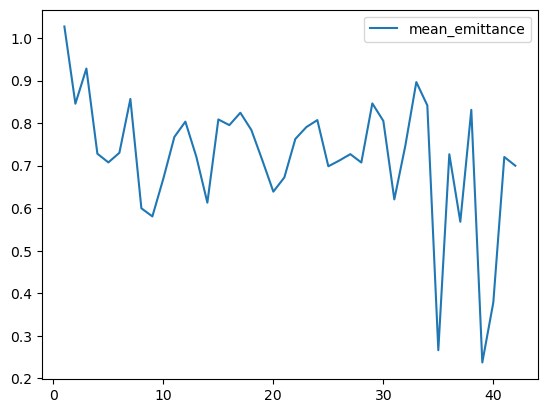

In [341]:
X.data.plot(y="mean_emittance")

<Axes: >

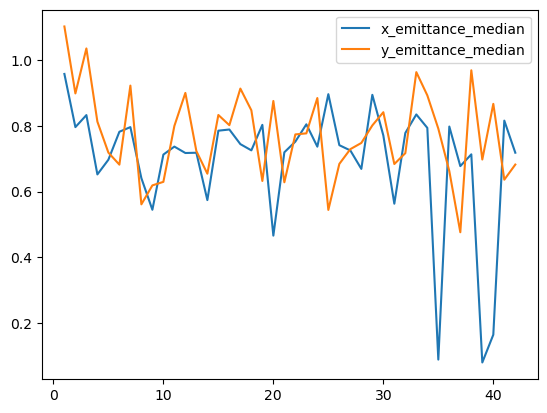

In [342]:
X.data.plot(y=["x_emittance_median","y_emittance_median"])

<Axes: >

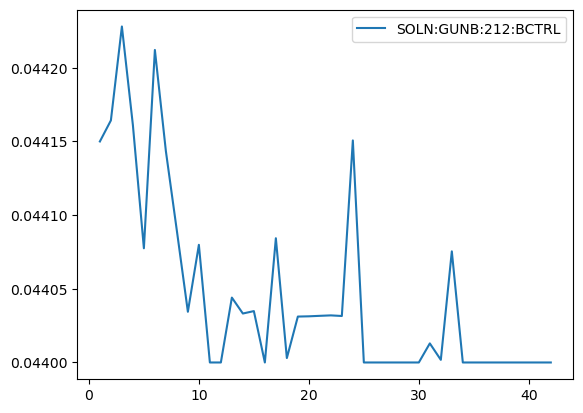

In [343]:
X.data.plot(y=["SOLN:GUNB:212:BCTRL"])

<Axes: >

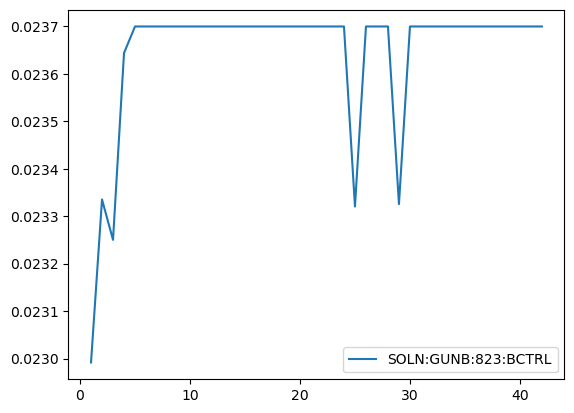

In [344]:
X.data.plot(y=["SOLN:GUNB:823:BCTRL"])

In [345]:
plot_sett_list = ['SOLN:GUNB:212:BCTRL',
 'QUAD:GUNB:212:1:BCTRL',
 'QUAD:GUNB:212:2:BCTRL',
 'SOLN:GUNB:823:BCTRL' ,
 'QUAD:GUNB:823:1:BCTRL',
 'QUAD:GUNB:823:2:BCTRL']

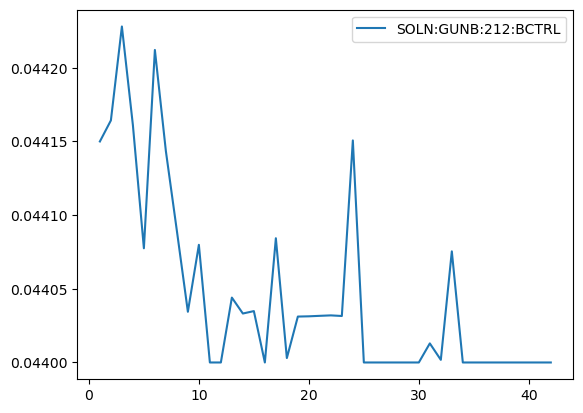

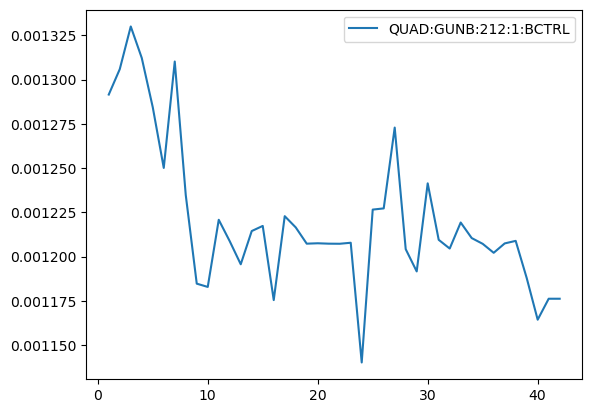

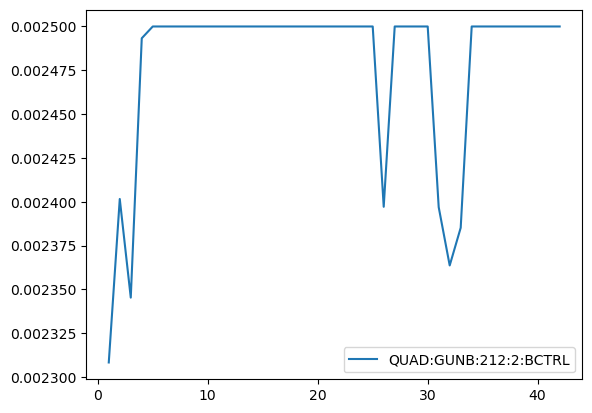

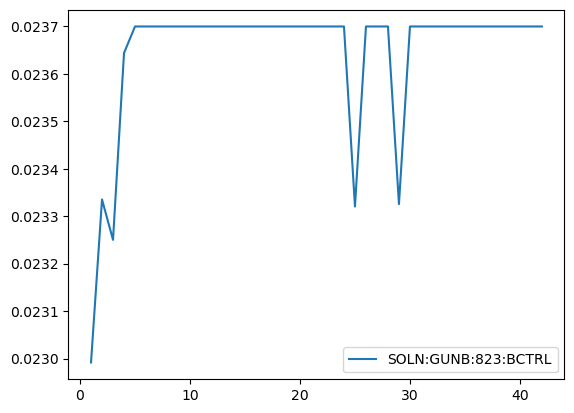

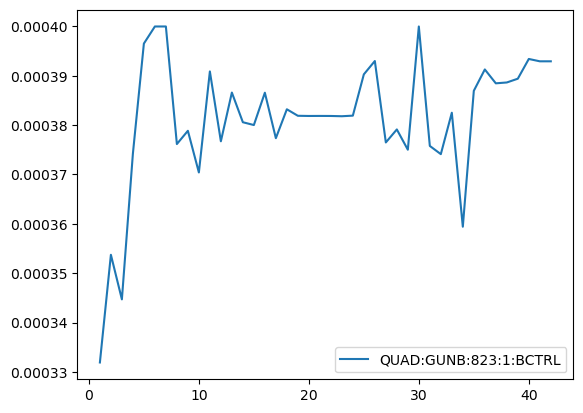

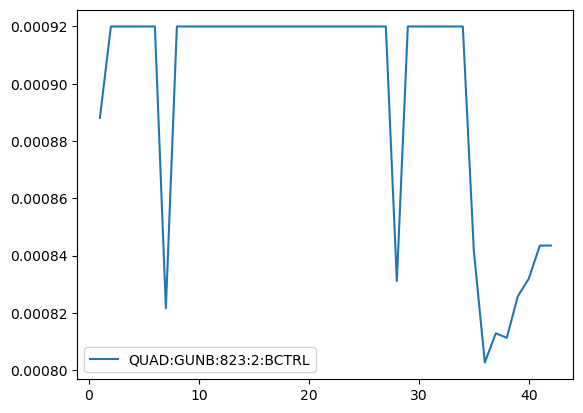

In [346]:
for var in plot_sett_list:
    X.data.plot(y=[var])